In [1]:
%%capture
!pip install ipython-autotime

%load_ext autotime

time: 2.51 ms (started: 2022-05-05 05:22:17 +00:00)


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive
time: 17.1 s (started: 2022-05-05 05:22:17 +00:00)


In [3]:
!cp -r '/content/gdrive/MyDrive/ESE_650_Project/data/' '/content/'

time: 2.5 s (started: 2022-05-05 05:22:34 +00:00)


In [4]:
import torch
from torch import nn
import torch.nn.functional as F

from tqdm import tqdm

import matplotlib.pyplot as plt

## scene loader 
import sys
import h5py
import json
import numpy as np
import random
import skimage.io
from skimage.transform import resize

import os

time: 3.99 s (started: 2022-05-05 05:22:36 +00:00)


# Seeding for reproducability

In [7]:
def seed_everything(seed=42):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(seed)

  return

seed_everything()

time: 5.65 ms (started: 2022-05-05 05:23:54 +00:00)


# Simulation environment setup

In [8]:
!cp -r '/content/gdrive/MyDrive/ESE_650_Project/bedroom_04.h5' '/content/' 

time: 2.22 s (started: 2022-05-05 05:23:54 +00:00)


In [9]:
!cp -r '/content/gdrive/MyDrive/ESE_650_Project/bathroom_02.h5' '/content/' 

time: 720 ms (started: 2022-05-05 05:23:56 +00:00)


In [10]:
!cp -r '/content/gdrive/MyDrive/ESE_650_Project/living_room_08.h5' '/content/' 

time: 1.66 s (started: 2022-05-05 05:23:57 +00:00)


In [11]:
!cp -r '/content/gdrive/MyDrive/ESE_650_Project/kitchen_02.h5' '/content/' 


time: 2.54 s (started: 2022-05-05 05:23:59 +00:00)


In [12]:
ACTION_SIZE = 4 # action size

SCREEN_WIDTH = 84
SCREEN_HEIGHT = 84
HISTORY_LENGTH = 4

time: 2.07 ms (started: 2022-05-05 05:24:01 +00:00)


In [14]:
## Scene Loader

# -*- coding: utf-8 -*-
class THORDiscreteEnvironment(object):

  def __init__(self, config=dict()):

    # configurations
    self.scene_name          = config.get('scene_name', 'bedroom_04')
    self.random_start        = config.get('random_start', True)
    self.n_feat_per_locaiton = config.get('n_feat_per_locaiton', 1) # 1 for no sampling
    self.terminal_state_id   = config.get('terminal_state_id', 0)

    self.h5_file_path = config.get('h5_file_path', 'data/%s.h5'%self.scene_name)
    self.h5_file      = h5py.File(self.h5_file_path, 'r')

    self.locations   = self.h5_file['location'][()]
    self.rotations   = self.h5_file['rotation'][()]
    self.n_locations = self.locations.shape[0]

    self.terminals = np.zeros(self.n_locations)
    self.terminals[self.terminal_state_id] = 1
    self.terminal_states, = np.where(self.terminals)

    self.transition_graph = self.h5_file['graph'][()]
    self.shortest_path_distances = self.h5_file['shortest_path_distance'][()]

    self.history_length = HISTORY_LENGTH
    self.screen_height  = SCREEN_HEIGHT
    self.screen_width   = SCREEN_WIDTH

    # we use pre-computed fc7 features from ResNet-50
    # self.s_t = np.zeros([self.screen_height, self.screen_width, self.history_length])
    self.s_t      = np.zeros([2048, self.history_length])
    self.s_t1     = np.zeros_like(self.s_t)
    self.s_target = self._tiled_state(self.terminal_state_id)

    self.reset()

  # public methods

  def reset(self):
    # randomize initial state
    while True:
      k = random.randrange(self.n_locations)
      min_d = np.inf
      # check if target is reachable
      for t_state in self.terminal_states:
        dist = self.shortest_path_distances[k][t_state]
        min_d = min(min_d, dist)
      # min_d = 0  if k is a terminal state
      # min_d = -1 if no terminal state is reachable from k
      if min_d > 0: break

    # reset parameters
    self.current_state_id = k
    self.s_t = self._tiled_state(self.current_state_id)

    self.reward   = 0
    self.collided = False
    self.terminal = False

  def step(self, action):
    assert not self.terminal, 'step() called in terminal state'
    k = self.current_state_id
    if self.transition_graph[k][action] != -1:
      self.current_state_id = self.transition_graph[k][action]
      if self.terminals[self.current_state_id]:
        self.terminal = True
        self.collided = False
      else:
        self.terminal = False
        self.collided = False
    else:
      self.terminal = False
      self.collided = True

    self.reward = self._reward(self.terminal, self.collided)
    self.s_t1 = np.append(self.s_t[:,1:], self.state, axis=1)

  def update(self):
    self.s_t = self.s_t1

  # private methods

  def _tiled_state(self, state_id):
    k = random.randrange(self.n_feat_per_locaiton)
    f = self.h5_file['resnet_feature'][state_id][k][:,np.newaxis]
    return np.tile(f, (1, self.history_length))

  def _reward(self, terminal, collided):
    # positive reward upon task completion
    if terminal: return 10.0
    # time penalty or collision penalty
    return -0.1 if collided else -0.01

  # properties

  @property
  def action_size(self):
    # move forward/backward, turn left/right for navigation
    return ACTION_SIZE 

  @property
  def action_definitions(self):
    action_vocab = ["MoveForward", "RotateRight", "RotateLeft", "MoveBackward"]
    return action_vocab[:ACTION_SIZE]

  @property
  def observation(self):
    return self.h5_file['observation'][self.current_state_id]

  @property
  def state(self):
    # read from hdf5 cache
    k = random.randrange(self.n_feat_per_locaiton)
    return self.h5_file['resnet_feature'][self.current_state_id][k][:,np.newaxis]

  @property
  def target(self):
    return self.s_target

  @property
  def x(self):
    return self.locations[self.current_state_id][0]

  @property
  def z(self):
    return self.locations[self.current_state_id][1]

  @property
  def r(self):
    return self.rotations[self.current_state_id]




time: 136 ms (started: 2022-05-05 05:24:24 +00:00)


In [20]:
# Select Scene

scenes_dict = {'1':'bedroom_04', '2':'kitchen_02', '3':'bathroom_02', '4':'living_room_08'}

print('choose scenes:')
print(scenes_dict)
print('Enter number for required scene: \nexample\n Enter \'1\' for bedroom_04 scene')
sc = input()
scene_name = scenes_dict[sc]
print(f'chosen scene: {scene_name}')

choose scenes:
{'1': 'bedroom_04', '2': 'kitchen_02', '3': 'bathroom_02', '4': 'living_room_08'}
Enter number for required scene: 
example
 Enter '1' for bedroom_04 scene
1
chosen scene: bedroom_04
time: 1.45 s (started: 2022-05-05 05:25:28 +00:00)


In [22]:
## load scene into environment

env = THORDiscreteEnvironment({
'random_start': True,
'scene_name': scene_name,
'h5_file_path': '%s.h5'%scene_name,
'terminal_state_id' : 134
})

print(env.scene_name)
print(env.terminal_state_id)

bedroom_04
134
time: 17 ms (started: 2022-05-05 05:25:50 +00:00)


Use w,a,s,d keys to move the agent.

w: move forward
a: rotate left
d: rotate right
s: move bakward

Press R to reset agent's location.
Press Q to quit.
Press key: d


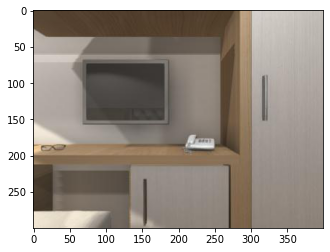

Press key: d


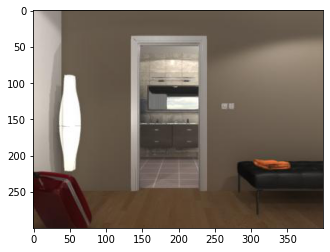

Press key: d


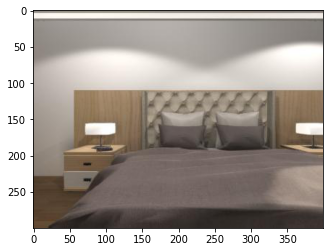

Press key: d


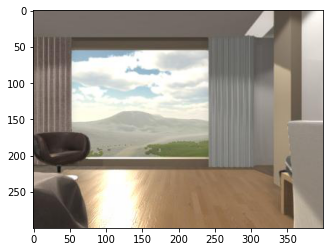

Press key: a


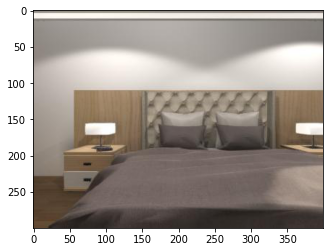

Press key: w


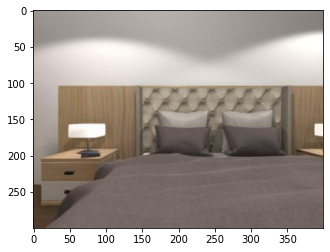

Press key: w
Collision occurs.


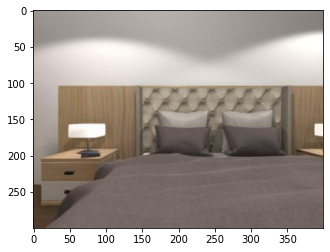

Press key: w
Collision occurs.


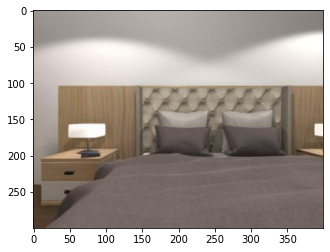

Press key: w
Collision occurs.


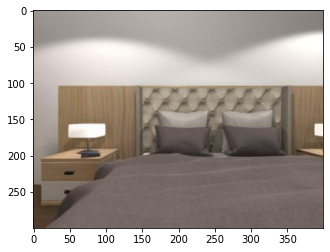

Press key: d


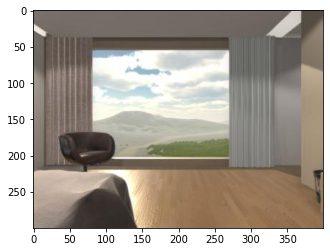

Press key: w


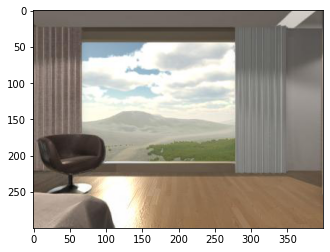

Press key: w


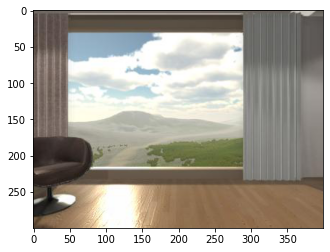

Press key: w


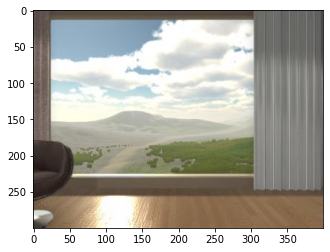

Press key: w


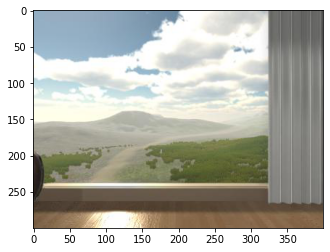

Press key: w


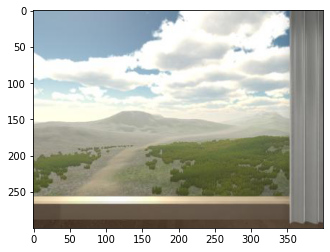

Press key: w


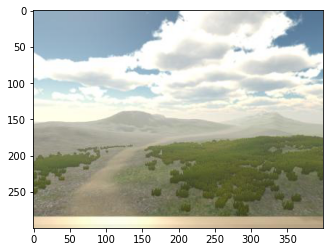

Press key: w


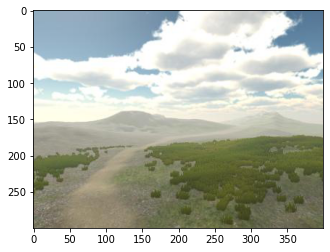

Press key: q
Goodbye.
time: 43.5 s (started: 2022-05-05 05:30:52 +00:00)


In [31]:
## Modified Keyboard Agent

from __future__ import print_function

import sys
import signal
import argparse
import numpy as np

#
# Navigate the scene using your keyboard
#

def key_press(key):

  global human_agent_action, human_wants_restart, stop_requested
  if key == 'R' or key == 'r': # r/R
    human_wants_restart = True
  if key == 'Q' or key == 'q': # q/Q
    stop_requested = True
  if key == 'w': # up
    human_agent_action = 0
  if key == 'd': # right
    human_agent_action = 1
  if key == 'a': # left
    human_agent_action = 2
  if key == 's': # down
    human_agent_action = 3

def rollout(env):

  global human_agent_action, human_wants_restart, stop_requested
  human_agent_action = None
  human_wants_restart = False
  while True:
    key = input("Press key: ")
    key_press(key)
    # waiting for keyboard input
    if human_agent_action is not None:
      # move actions
      env.step(human_agent_action)
      human_agent_action = None

    # waiting for reset command
    if human_wants_restart:
      # reset agent to random location
      env.reset()
      human_wants_restart = False

    # check collision
    if env.collided:
      print('Collision occurs.')
      env.collided = False

    # check quit command
    if stop_requested: break

    # viewer.imshow(env.observation)
    plt.imshow(env.observation)
    plt.show()


# manually disable terminal states
env.terminals = np.zeros_like(env.terminals)
env.terminal_states, = np.where(env.terminals)
env.reset()

human_agent_action = None
human_wants_restart = False
stop_requested = False

# viewer = SimpleImageViewer()
# viewer.imshow(env.observation)
# viewer.window.on_key_press = key_press

print("Use w,a,s,d keys to move the agent.")
print()
print("w: move forward")
print("a: rotate left")a
print("d: rotate right")
print("s: move bakward")
print()
print("Press R to reset agent\'s location.")
print("Press Q to quit.")

rollout(env)

print("Goodbye.")